In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("HD_processed.csv")
df.info()
print(df.shape)
pd.set_option("display.max_rows", None, "display.max_columns", None)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35144 entries, 0 to 35143
Data columns (total 27 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Unique_ID                                          35144 non-null  int64  
 1   Invoice_Date                                       35144 non-null  object 
 2   Customer_Id                                        35144 non-null  int64  
 3   Warehouse                                          35144 non-null  object 
 4   Postal_Code                                        35144 non-null  int64  
 5   Customer_MarketSegment_Id                          35144 non-null  object 
 6   Sales_Order_Id                                     35144 non-null  object 
 7   Created_Date                                       35144 non-null  object 
 8   Job_Description                                    35144 non-null  object 
 9   Source

In [2]:
df2 = df.copy()
df2 = df2.drop('Unique_ID', 1)
df2 = df2.drop('Invoice_Date', 1)
df2 = df2.drop('Customer_Id', 1)
df2 = df2.drop('Warehouse', 1)
df2 = df2.drop('Postal_Code', 1)
df2 = df2.drop('Sales_Order_Id', 1)
df2 = df2.drop('Created_Date', 1)
df2 = df2.drop('Job_Description', 1)
df2 = df2.drop('Real_Invoice_Date', 1)
df2 = df2.drop('Quarter', 1)
df2 = df2.drop('BigCustomer', 1)
df2 = df2.drop('Quantile_transactions', 1)
df2 = df2.drop('Distance_to_Toowoomba(km)', 1)
df2 = df2.drop('Monthly_rainfall(mm)', 1)
df2 = df2.drop('Value_building_jobs(private_sector_AUD_thousands)', 1)
df2['Month'] = df2['Month'].astype("object")
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35144 entries, 0 to 35143
Data columns (total 12 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Customer_MarketSegment_Id                  35144 non-null  object 
 1   Source_Of_Supplier_Id                      35144 non-null  object 
 2   Major_Minor_Class                          35144 non-null  object 
 3   Sales_Channel                              35144 non-null  object 
 4   Processing_time(days)                      35144 non-null  int64  
 5   Month                                      35144 non-null  object 
 6   Highest_daily_rainfall                     35144 non-null  float64
 7   Highest_daily_temprature(C)                35144 non-null  float64
 8   Number_building_approvals(private_sector)  35144 non-null  int64  
 9   Producer_price_index(brisbane)             35144 non-null  float64
 10  Monthly_transactions  

In [3]:
df_dum = pd.get_dummies(df2, columns = ['Customer_MarketSegment_Id', 'Source_Of_Supplier_Id', 'Major_Minor_Class', 'Sales_Channel', 'Month'])
print(df_dum.shape)

(35144, 202)


In [4]:
Y = df_dum["Monthly_transactions"]
X = df_dum.drop('Monthly_transactions', 1)
print(Y.shape)
print(X.shape)

(35144,)
(35144, 201)


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state = 42)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(24600, 201)
(10544, 201)
(24600,)
(10544,)


(24600, 201)
(10544, 201)


Text(0.5, 1.0, 'X_train_standard')

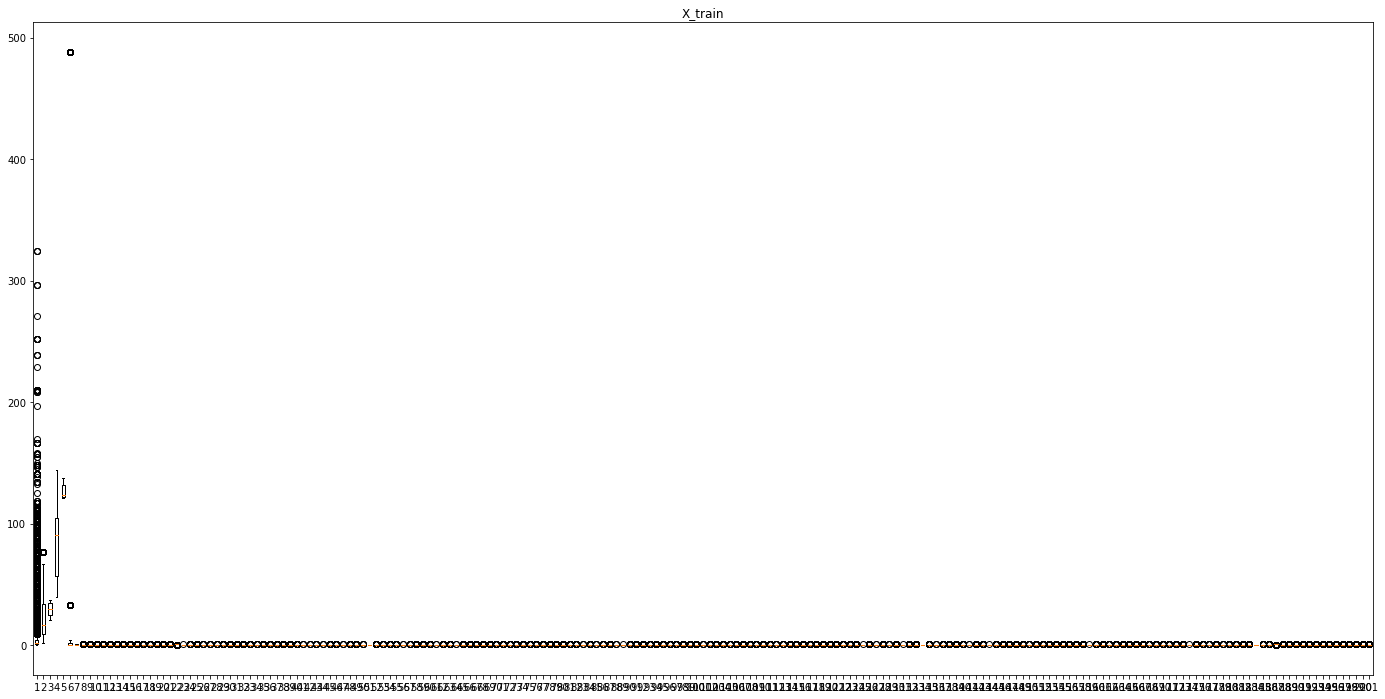

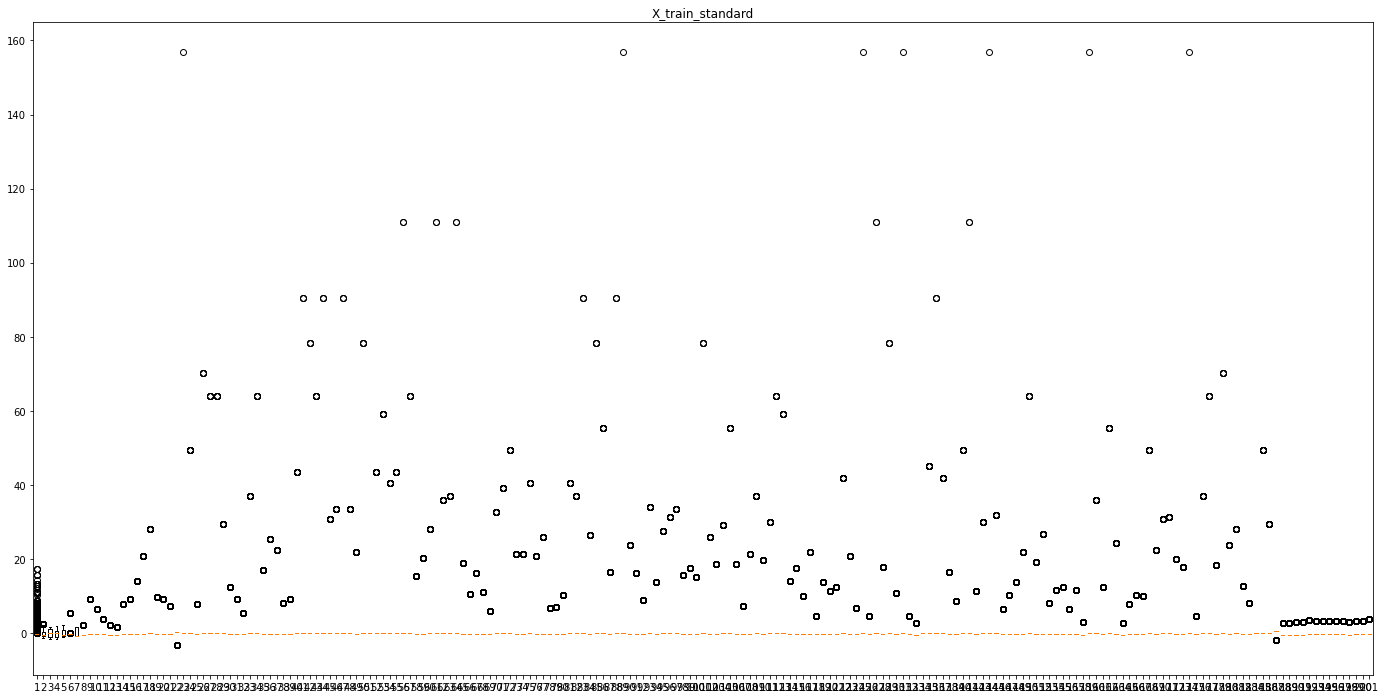

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_standard = scaler.fit_transform(X_train)
X_test_standard = scaler.fit_transform(X_test)
print(X_train_standard.shape)
print(X_test_standard.shape)

fig = plt.figure(figsize = [24, 12])
ax = fig.add_subplot(1, 1, 1)
ax.boxplot(X_train)
ax.set_title("X_train")

fig = plt.figure(figsize = [24, 12])
ax = fig.add_subplot(1, 1, 1)
ax.boxplot(X_train_standard)
ax.set_title("X_train_standard")

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

model = RandomForestRegressor(n_estimators = 32, max_depth = 17, random_state=42, n_jobs = -1)
model.fit(X_train_standard, Y_train)

print(model.score(X_train_standard, Y_train))
# The mean squared error
print("Mean squared error(training): %.3f" % mean_squared_error(Y_train, model.predict(X_train_standard)))
print("Mean squared error(testing): %.3f" % mean_squared_error(Y_test, model.predict(X_test_standard)))

print("R2(training): %.3f" % r2_score(Y_train, model.predict(X_train_standard)))
print("R2(testing): %.3f" % r2_score(Y_test, model.predict(X_test_standard)))

0.549530044052124
Mean squared error(training): 301.359
Mean squared error(testing): 413.916
R2(training): 0.550
R2(testing): 0.381


In [8]:
from sklearn.model_selection import RandomizedSearchCV
from time import process_time

time_start = process_time()

parameter = {'n_estimators' : list(range(10,50)), 'max_depth' : list(range(5,35))}
grid = RandomizedSearchCV(model, parameter, cv = 5, n_jobs=-1, n_iter = 20)
grid.fit(X_train_standard, Y_train)
grid.cv_results_
print("best hyper-parameters: " + str(grid.best_params_))
print("validation accuracy: " + str(grid.best_score_))

time_end = process_time()
print('Time spent:   %f seconds' % (time_end - time_start))

<AxesSubplot:>

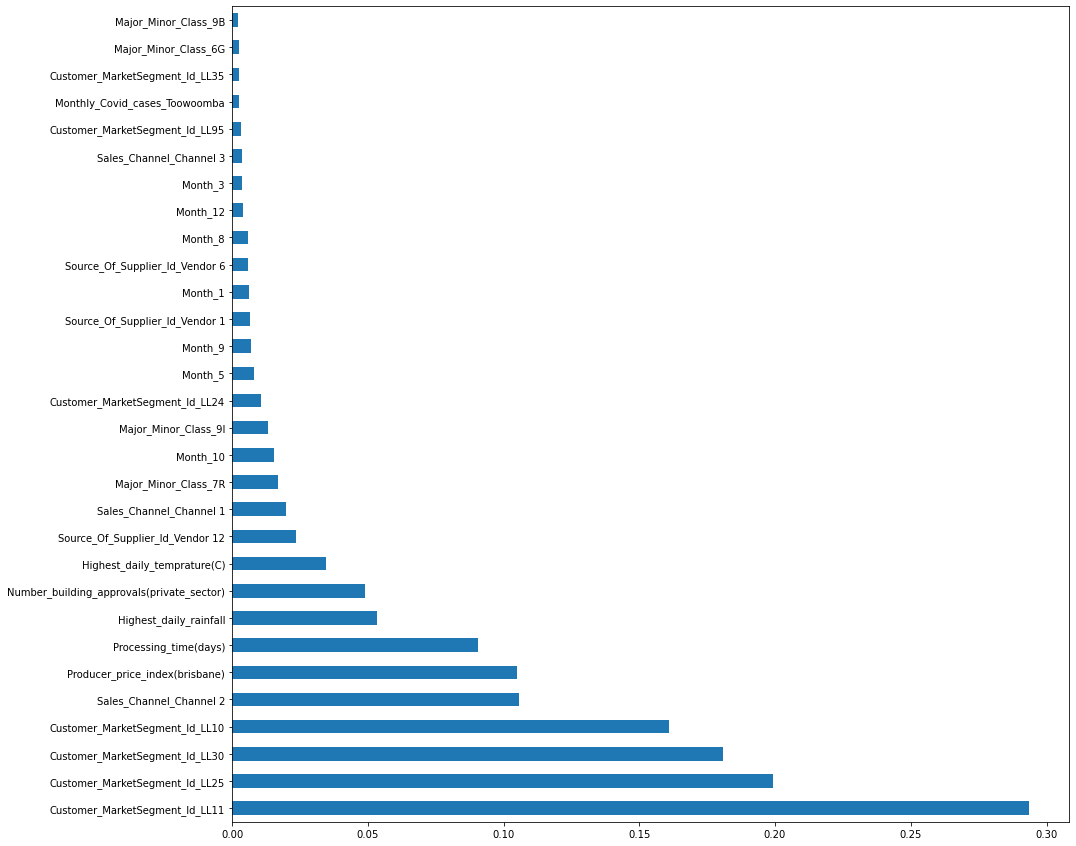

In [9]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_test_standard, Y_test, n_repeats=30, random_state=42, n_jobs=-1)
permutation_importances = pd.Series(result.importances_mean, index = X_train.columns)
permutation_importances.nlargest(30).plot(kind='barh', figsize=(15,15))

In [10]:
from sklearn import linear_model
poisson = linear_model.PoissonRegressor().fit(X_train_standard, Y_train)

print(poisson.score(X_train_standard, Y_train))
# The mean squared error
print("Mean squared error(training): %.3f" % mean_squared_error(Y_train, poisson.predict(X_train_standard)))
print("Mean squared error(testing): %.3f" % mean_squared_error(Y_test, poisson.predict(X_test_standard)))

print("R2(training): %.3f" % r2_score(Y_train, poisson.predict(X_train_standard)))
print("R2(testing): %.3f" % r2_score(Y_test, poisson.predict(X_test_standard)))

0.18656540622951878
Mean squared error(training): 559.343
Mean squared error(testing): 561.845
R2(training): 0.164
R2(testing): 0.160
